# Recurrent Neural Networks

## Introduction

**Recurrent Neural Networks (RNNs)** are a type of neural network designed for processing sequential data, such as time series, text, or any data with temporal dependencies. Unlike traditional neural networks, RNNs have loops that allow information to persist, making them well-suited to sequences where previous information is relevant to understanding the current state.

In an RNN, each element in a sequence is processed one at a time, with each step’s output influenced by both the input at that time step and the hidden state from the previous step. This design enables RNNs to maintain a form of memory, capturing dependencies across time. 

RNNs are widely used in tasks such as language modeling, speech recognition, and predictive analytics, where understanding past information is essential to predicting future events. In general, RNNs can be used in several settings, as pictured below:

<img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width = 500>

Examples of the settings in the picture:

- _One to one_: vanilla MLPs that map a fixed-size vector to another vector for classification or regression.
- _One to many_: Image captioning, given an input embedding (obtained with a CNN), a textual caption of variable length is generated.
- _Many to one_: (1) Sentence classification such as sentiment analysis or (2) image generation from text. In both cases variable-length input texts are given as input and a fixed-size vector is generated.
- _Many to many_: (1) Machine translation of a variable-length sentence to another variable-length sentence or (2) transcription of a variable-length .mp3 audio to a variable-length text.
- _Many to many (1-to-1 correspondence)_: (1) Video classification where one label for a variable number of frames in the video is predicted (the video frame embedding can be obtained with a CNN and then fed into a RNN), (2) autoregressive language modeling where the next word in the sentence is predicted for generative purposes or (3) word classification where every word is classified as belonging to a category.

Note that these settings are not exclusive to RNNs. In fact, any network type that works on variable-length input sequences can be used towards these ends. Most famously of which are of course, **Transformers**, which have all but replaced RNNs in NLP and many other fields. An explanation and implementation of Transformers is out of the scope for this course. It suffices to know that RNNs process input sequence sequentially through memory cells, whereas Transformers do it in parallel through an $N \times N$ attention matrix, with $N$ the number of input tokens/vectors. Other than RNNs and Transformers, convnets can also be used on variable-length inputs: a 1D kernel can equally well convolve over a sequence of length $100$ as $1000$. It is only because of the fully-connected layers at the end of the network that typical CNNs are applicable on fixed-size inputs only.

## Part 1: Autoregressive modelling

Autoregressive modelling is the task of trying to predict the next token in a sequence, given previous tokens. In this PC-lab we will explore autoregressive modelling techniques on a particular dataset from the city of Ghent, called *Fietstelpaal Coupure-Links 2023 Gent*.

<img src="https://images0.persgroep.net/rcs/4cQwm-ofvb3eyIKMWnNf5axxLHg/diocontent/217261403/_fitwidth/694/?appId=21791a8992982cd8da851550a453bd7f&quality=0.8" width = 500>

The processed dataset contains data from the [Coupure-Links bicycle counter](https://data.stad.gent/explore/dataset/fietstelpalen-gent/table/) for the year 2023 and consists of the following variables:

* Date_hour: date and hour encoded in the following format: YYYY-MM-DDTHH.
* Totaal: the total number of cyclists that passed the counter.

Let's start with the exploration of our datasets.

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn

import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/tfmortie/mlcourse/main/11_rnns/train_data.csv", "./train_data.csv")
urllib.request.urlretrieve("https://raw.githubusercontent.com/tfmortie/mlcourse/main/11_rnns/test_data.csv", "./test_data.csv")

train_data = pd.read_csv("train_data.csv", sep = ",")
test_data = pd.read_csv("test_data.csv", sep = ",")

train_data

,Date_hour,Totaal
0,2023-01-01T00,111.0
1,2023-01-01T01,201.0
2,2023-01-01T02,170.0
3,2023-01-01T03,144.0
4,2023-01-01T04,155.0
...,...,...
4338,2023-06-30T19,465.0
4339,2023-06-30T20,325.0
4340,2023-06-30T21,260.0
4341,2023-06-30T22,239.0


Let's encode the hour as separate feature.

In [2]:
train_data["Hour"] = train_data["Date_hour"].str.split("T", expand = True)[1].astype(float)
test_data["Hour"] = test_data["Date_hour"].str.split("T", expand = True)[1].astype(float)
train_data.head()

,Date_hour,Totaal,Hour
0,2023-01-01T00,111.0,0.0
1,2023-01-01T01,201.0,1.0
2,2023-01-01T02,170.0,2.0
3,2023-01-01T03,144.0,3.0
4,2023-01-01T04,155.0,4.0


Architecturally, autoregressive modelling of a timeseries looks like this:

<img src="https://raw.githubusercontent.com/tfmortie/mlcourse/main/11_rnns/AR.png" width = 500>

For every point in the timeseries, the *input token* consists of the value at that timepoint and, optionally, extra covariates pertaining to that timepoint. Conceptually, this is similar to the channels in a CNN, as there we also had input tokens (e.g. pixels) with multiple values (e.g. the 3 RGB values) per token. In our case, extra covariates could be for example the hour at which that timepoint was taken. This input sequence will go into the RNN, which will keep a hidden layer which acts as a memory bank. The memory bank of every input will consist of a combination of the information at that time point and the information coming in from the memory cell at the previous time point. The specific way this information is brought together depends on the specific construction of the RNN. We refer you to the theory lectures for details. The most popular constructions are the LSTM and the GRU memory cells. For every timestep, the model outputs a vector which (for this purpose) needs to be linearly recombined to one number as our goal is to predict the value of the next timestep (i.e. a regression task).

Code-wise, it is important to know that for a given sequence, we have an input $x$ consisting of the timepoints in that sequence, and an output $y$, consisting of the same points, but **shifted one time-step to the left**. **Because of the directionality of the RNN, for every time-step, it will predict the next point given only the preceding ones.**

In this PC-lab, we will use the hour of the timepoint as covariate.

For training, we can't put all days in to our model as one sample. Just like the reason for doing batches in other networks is that: it is more computationally efficient, and it allows us to have training steps on different parts of data with some stochasticity to it, allowing us to jump out of local minima.

**For RNNs, another reason is that our "actual" neural network depth is essentially decided by our input length**, so if we send in a sample containing a thousand input tokens, we also backpropagate through a thousand layers, and our computers will surely crash. In addition, it is not reasonable to assume the number of cyclists hundreds of days past still influences the number of cyclists now. So, the problem of batching our sequence becomes one of weighing two factors: how long of a sequence can our model handle, and how much context (in number of preceding tokens) do our models need for prediction?

Here we will take a batch size of 48 as a default, meaning that our samples will always coincide with two consecutive days.

In [4]:
def generate_batches(sequence, seqlen = 48):
    batches = []
    for i in np.arange(0, len(sequence) - seqlen, seqlen):
        batches.append(sequence[i:i+seqlen])
    return torch.stack(batches)

train_batches = generate_batches(torch.tensor(train_data[["Hour", "Totaal"]].values.astype(np.float32)))

Let's see how a sample looks like:

In [5]:
train_batches.shape

torch.Size([90, 48, 2])

In [6]:
train_batches[0]

tensor([[  0., 111.],
        [  1., 201.],
        [  2., 170.],
        [  3., 144.],
        [  4., 155.],
        [  5., 140.],
        [  6., 109.],
        [  7.,  75.],
        [  8.,  43.],
        [  9.,  42.],
        [ 10.,  50.],
        [ 11.,  76.],
        [ 12.,  94.],
        [ 13., 113.],
        [ 14., 125.],
        [ 15., 173.],
        [ 16., 109.],
        [ 17., 100.],
        [ 18., 116.],
        [ 19.,  67.],
        [ 20., 120.],
        [ 21.,  82.],
        [ 22.,  60.],
        [ 23.,  29.],
        [  0.,  11.],
        [  1.,  10.],
        [  2.,   2.],
        [  3.,   5.],
        [  4.,  15.],
        [  5.,  33.],
        [  6.,  58.],
        [  7., 169.],
        [  8., 257.],
        [  9., 198.],
        [ 10., 129.],
        [ 11., 123.],
        [ 12., 206.],
        [ 13., 200.],
        [ 14., 192.],
        [ 15., 208.],
        [ 16., 266.],
        [ 17., 363.],
        [ 18., 299.],
        [ 19., 177.],
        [ 20.,  74.],
        [ 

We could give our input to the model like this, as the hour is a numerical value which can be interpreted using linear layers. It would make more sense to treat the hour variable as categorical and encode it using dummy variables (one-hot encoding).

In [7]:
one_hot_hour = torch.nn.functional.one_hot(train_batches[:, :, 0].long())

one_hot_hour.shape

torch.Size([90, 48, 24])

In [8]:
train_batches = torch.cat([train_batches[:, :, [1]], one_hot_hour], axis = 2)

In [9]:
train_batches.shape

torch.Size([90, 48, 25])

In [10]:
train_batches[0]

tensor([[111.,   1.,   0.,  ...,   0.,   0.,   0.],
        [201.,   0.,   1.,  ...,   0.,   0.,   0.],
        [170.,   0.,   0.,  ...,   0.,   0.,   0.],
        ...,
        [  8.,   0.,   0.,  ...,   1.,   0.,   0.],
        [  7.,   0.,   0.,  ...,   0.,   1.,   0.],
        [ 21.,   0.,   0.,  ...,   0.,   0.,   1.]])

Let's min-max scale the outputs. Remember: if you don't do this, your loss function will be of a very big scale, affecting learning (i.e. you will need lower learning rates).
Hence, scaling allows us to make a better guess as to what a good learning rate will be.

In [11]:
max_cyclists_train = train_batches[:, :, 0].max()
min_cyclists_train = train_batches[:, :, 0].min()
train_batches[:, :, 0] = (train_batches[:, :, 0]-min_cyclists_train)/(max_cyclists_train-min_cyclists_train)
train_batches

tensor([[[0.0583, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.1056, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0893, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0042, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.0037, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0110, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],

        [[0.0063, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0016, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0688, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
         [0.0678, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
         [0.0494, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],

        [[0.0163, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0095, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0037, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.

Finally, let's prepare some batches in a similar way for the test set:

In [ ]:
test_batches = generate_batches(torch.tensor(test_data[["Hour", "Totaal"]].values.astype(np.float32)))
one_hot_hour = torch.nn.functional.one_hot(test_batches[:, :, 0].long())
test_batches = torch.cat([test_batches[:, :, [1]], one_hot_hour], axis = 2)
test_batches[:, :, 0] = (test_batches[: ,: ,0]-min_cyclists_train)/(max_cyclists_train-min_cyclists_train)
test_batches[0]

tensor([[0.0788, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0483, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0257, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0904, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0788, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0504, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]])

### RNNs in PyTorch

In this PC-lab we will use the GRU, but note that other RNN-types work similarly in PyTorch.

[Documentation for the GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

_Note_: The weird shape expectations (such as not expecting batches to come first by default) are a consequence of optimizations that PyTorch has implemented so the RNNs run efficiently on data with variable input sequence lengths (such as sentences). For this PC lab, we have batched our sequences so that they have constant sequence length, so we can add the argument `batch_first = True`.

Let's create a GRU and some toy data to see how it all works:

In [12]:
gru = nn.GRU(input_size = 64, hidden_size = 512, batch_first = True)

In [13]:
x = torch.randn(2, 50, 64)
output, h_n = gru(x)
output.shape, h_n.shape

(torch.Size([2, 50, 512]), torch.Size([1, 2, 512]))

Explanation of the outputs: `h_n` is the hidden representation of the last hidden memory cell. It can be seen as a summarized representation of the content of the whole input (if one wants a single output for a whole sequence as in e.g. sentence classification). `output` will return the output representation of the RNN for every input token: look back at the picture in the introduction of this part of the PC lab for more intuition. 

For autoregressive modeling of time series, we should have an output for every input, mainly: the prediction of the next timepoint. For our purpose, we are interested to predict a single output per timepoint, whereas we can see that this is not the case for our GRU model as it is now. We can remedy this with a simple linear layer

<div class="alert alert-success">

<b>EXERCISE:</b>
<p> Implement an autoregressive GRU for cycler forecasting by completing the code below. The model should contain a recurrent layer, and a layer that takes the outputs of the GRU at each timestep and manipulates their dimensions so that the output dimensionality of each token is equal to one. Keep in mind how many input variables we have in our dataset.
</p>

</div>

Test your model with some toy data down below.



In [13]:
class CyclerForecaster(nn.Module):
    def __init__(self, input_dim = 25, hidden_dim = 64):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, batch_first = True)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        output, _ = self.gru(x)
        return self.output_head(output)

In [14]:
model = CyclerForecaster()

x = torch.randn(2, 48, 25)

y = model(x)

y.shape

torch.Size([2, 48, 1])

To create an input and an output, we have to do the above-mentioned shifting. In practice, this means that we take all but the last timepoints to create X, and all but the first timepoints to create Y, hence creating shifted X,Y pairs.

Additionally, for Y, we only want to keep the first variable, meaning the number of cyclists itself.

In [17]:
X_train = train_batches[:, :-1]

y_train = train_batches[:, 1:]
y_train = y_train[:, :, [0]]

print(X_train.shape, y_train.shape)

torch.Size([90, 47, 25]) torch.Size([90, 47, 1])


Doing the same for the test data, and putting the things into datasets and dataloaders.

In [18]:
X_test = test_batches[:, :-1]
y_test = test_batches[:, 1:, [0]]

train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

Note that we are just taking the first 80% of the data as training and the last 20% as validation set. Normally, we shuffle our data so that we are not biased. In this case, however, we can make a case for doing it our way: because the samples are ordered by day and month, the last samples will be from the summer months, where we may expect different patterns (June: exams, July: vacations).

<div class="alert alert-success">

<b>EXERCISE:</b>
<p> Implement the training loop for the Cycler Forecaster using the same principles from last PC labs. Keep in mind that unlike previous PC labs, we are now training a regression task. You will also need to increase the number of epochs as our dataset is quite small and each epoch only constitutes a small number of training steps.
</p>

</div>


In [ ]:
N_EPOCHS = 250

model = CyclerForecaster()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005) 

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)

    print(i, '\t', train_loss, np.mean(losses))

1 	 0.03790270863100886 0.008453572168946266
2 	 0.02517694824685653 0.009773558005690575
3 	 0.020987652940675616 0.006167578510940075
4 	 0.01763850908416013 0.004615579731762409
5 	 0.01608794399847587 0.004493154818192124
6 	 0.014426465767125288 0.004796544788405299
7 	 0.014205804715553919 0.004695741226896644
8 	 0.013654466097553572 0.004703005077317357
9 	 0.012340439561133584 0.004058361519128084
10 	 0.012084053208430609 0.004790138220414519
11 	 0.010748255842675766 0.003993422607891262
12 	 0.010015741766740879 0.00425271806307137
13 	 0.009584713339184722 0.004295289516448975
14 	 0.009034720210668942 0.004169565159827471
15 	 0.008990443660877645 0.004498346126638353
16 	 0.008489450556226075 0.004561572801321745
17 	 0.008249515589947501 0.004384944913908839
18 	 0.007933271233923733 0.004626402631402016
19 	 0.007796141668222845 0.004508990561589599
20 	 0.007731840984585385 0.004747357685118914
21 	 0.007386073217882465 0.0046094071585685015
22 	 0.007323010979841153 

To evaluate our model beyond looking at a loss function going down: we can look at the autoregressive results for a random test sample:

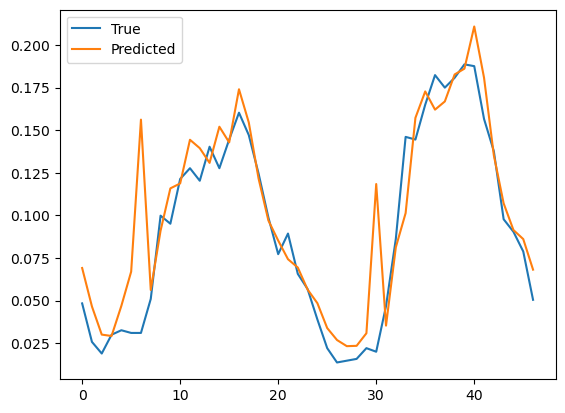

In [20]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(y_test[0])), y_test[0])
plt.plot(np.arange(len(y_test[0])), model(X_test[[0]]).detach().squeeze(0).numpy())
plt.legend(["True", "Predicted"])
plt.show()

You should see that at the beginning of the second day, the model overshoots its prediction by a wide margin. This is because most probably the next day is a weekend day. After that, for the prediction of the next step, we give it the true input of that (previously-wrongly predicted) timestep, and because it recognizes that by this low value it should be a weekend day, the subsequent predictions are also low.



This is not really forecasting though: at every timestep, we are predicting only one timestep (hour) in advance. To really do forecasting for a longer time limit, we should feed the predictions of the model back into the model, like this:

<img src="https://raw.githubusercontent.com/tfmortie/mlcourse/main/11_rnns/generation.png" width = 500>

To perform this, we will create a helper function that extracts the next step:

In [20]:
def generate_next_timestep(previous, model):
    with torch.no_grad():
        output = model(previous.unsqueeze(0))[0, -1]

    return output

def generate_n_timesteps(previous, model, n = 5):
    for _ in range(n):
        prediction = generate_next_timestep(previous, model)
        # to make a next prediction, we not only need to add the prediction but also the covariates (hour) to our next input:
        next_timestep_hour = nn.functional.one_hot((previous[-1, 1:].argmax() + 1) % 24, num_classes = 24)
        new_input = torch.cat([prediction, next_timestep_hour])
        previous = torch.cat([previous, new_input.unsqueeze(0)])

    return previous[:, 0]

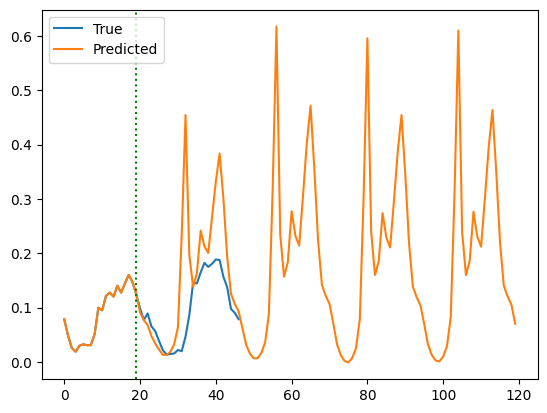

In [21]:
sample_index = 0
priming_points = 20
generate_steps = 100


plt.plot(np.arange(len(X_test[sample_index])), X_test[sample_index, :, 0])
predictions = generate_n_timesteps(X_test[sample_index, :priming_points], model, n = generate_steps).numpy()
plt.plot(np.arange(len(predictions)), predictions)
plt.axvline(x = priming_points-1, color = "green", linestyle = ":")
plt.legend(["True", "Predicted"])
plt.show()

<div class="alert alert-success">

<b>THOUGHT EXERCISE:</b>
<p> Play around with the code for forecasting bicyclists by changing up which sample you forecast ("sample_index"), how much initial input points you give the model ("priming points") and how far in time it should generate after that ("generate steps"). Can you find obvious failure states? Can you think of ways how to remedy these failure modes?
</p>

</div>

Written answer:
If the priming point is a friday and the next day a weekend day, it will still predict high numbers for the weekend. Additionally, when generating a lot of days, after a while the same pattern is predicted for every day.

**Solution**: The model doesn't know what day of the week it is, resulting in a behavior in which the best the model can do is predict "the average day". One could encode more features for every timepoint in addition to just which hour it was, such as which day of the week it is. In addition, one could add weather and temperature variables to the model, so that the model can account for seasonal and weather impacts on the prediction. One could even go as far as adding an indicator variable that indicates whether a day is a Belgian holiday ...

## Part 2: time series classification

In the next part, we will explore a many-to-one scenario. To keep things simple, we will work on the same dataset and try to predict from the series of a single day whether that day was a weekend or a weekday.

To do this, we first need to know which days were weekdays:

In [22]:
train_data

,Date_hour,Totaal,Hour
0,2023-01-01T00,111.0,0.0
1,2023-01-01T01,201.0,1.0
2,2023-01-01T02,170.0,2.0
3,2023-01-01T03,144.0,3.0
4,2023-01-01T04,155.0,4.0
...,...,...,...
4338,2023-06-30T19,465.0,19.0
4339,2023-06-30T20,325.0,20.0
4340,2023-06-30T21,260.0,21.0
4341,2023-06-30T22,239.0,22.0


Following code adds an indicator variable to the data that signifies if the date is a weekday or not. We'll use this as "y" values to predict

In [23]:
from datetime import datetime
def isweekday(date):
    return datetime.fromisoformat(date).weekday() < 5

train_data["Date"] = train_data["Date_hour"].str.split("T", expand = True)[0]
test_data["Date"] = test_data["Date_hour"].str.split("T", expand = True)[0]

train_data["isweekday"] = [int(isweekday(i)) for i in train_data["Date"]]
test_data["isweekday"] = [int(isweekday(i)) for i in test_data["Date"]]
train_data



,Date_hour,Totaal,Hour,Date,isweekday
0,2023-01-01T00,111.0,0.0,2023-01-01,0
1,2023-01-01T01,201.0,1.0,2023-01-01,0
2,2023-01-01T02,170.0,2.0,2023-01-01,0
3,2023-01-01T03,144.0,3.0,2023-01-01,0
4,2023-01-01T04,155.0,4.0,2023-01-01,0
...,...,...,...,...,...
4338,2023-06-30T19,465.0,19.0,2023-06-30,1
4339,2023-06-30T20,325.0,20.0,2023-06-30,1
4340,2023-06-30T21,260.0,21.0,2023-06-30,1
4341,2023-06-30T22,239.0,22.0,2023-06-30,1


With this data added, we can process our data into X and y:

In [24]:
train_batches = generate_batches(torch.tensor(train_data[["isweekday", "Hour", "Totaal"]].values.astype(np.float32)), seqlen = 24)
one_hot_hour = torch.nn.functional.one_hot(train_batches[:, :, 1].long())
train_batches = torch.cat([train_batches[:, :, [0, 2]], one_hot_hour], axis = 2)
train_batches[:, :, 1] = train_batches[:, :, 1] / max_cyclists_train

y_train = train_batches[:, 0, 0]
X_train = train_batches[:, :, 1:]
X_train.shape, y_train.shape

(torch.Size([180, 24, 25]), torch.Size([180]))

In [25]:
X_train[0]

tensor([[0.0583, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1056, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0893, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0757, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0815, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000,
       

The same for test data:

In [26]:
test_batches = generate_batches(torch.tensor(test_data[["isweekday", "Hour", "Totaal"]].values.astype(np.float32)), seqlen = 24)
one_hot_hour = torch.nn.functional.one_hot(test_batches[:, :, 1].long())
test_batches = torch.cat([test_batches[:, :, [0, 2]], one_hot_hour], axis = 2)
test_batches[:, :, 1] = test_batches[:, :, 1] / max_cyclists_train

y_test = test_batches[:, 0, 0]
X_test = test_batches[:, :, 1:]
X_test.shape, y_test.shape

(torch.Size([30, 24, 25]), torch.Size([30]))

Examine if the shapes are conforming to your expectations as to what we expect it to be for timeseries classification. What does every dimension in X and y signify?

In [27]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size = 8, shuffle = True)

test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle = True)

<div class="alert alert-success">

<b>EXERCISE:</b>
<p> Implement a time series classification model by copying the code above and adapting it.

Steps you need to take:
- Change the RNN model so that it is adapted for many to one tasks
- Change the loss function for binary classification
- Implement a way to keep track of accuracies instead of only losses
</p>

</div>

You should be able to obtain an accuracy of at least 85%.

In [28]:
class TimeseriesClassifier(nn.Module):
    def __init__(self, input_dim = 25, hidden_dim = 64):
        super().__init__()
        self.gru = nn.GRU(input_size = input_dim, hidden_size = hidden_dim, batch_first = True)
        self.output_head = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, output = self.gru(x)
        return self.output_head(output[0])[:, 0]

In [29]:
N_EPOCHS = 250

model = TimeseriesClassifier()

loss_function = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) # SGD = stochastic gradient descent

for i in range(1, N_EPOCHS + 1):
    all_losses = []
    model.train()
    for batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = batch

        y_hat_batch = model(X_batch)

        loss = loss_function(y_hat_batch, y_batch) # Compute loss

        loss.backward()   # Calculate gradients
        optimizer.step()   # Update weights using defined optimizer

        all_losses.append(loss.item())
    train_loss = np.mean(all_losses)

    predictions = []
    true_labels = []
    losses = []

    with torch.no_grad():
        model.eval()
        for batch in test_dataloader:
            X_batch, y_batch = batch

            y_hat_batch = model(X_batch)

            loss = loss_function(y_hat_batch, y_batch)

            losses.append(loss.item())
            predictions.append(y_hat_batch)
            true_labels.append(y_batch)

    predictions = torch.cat(predictions)
    true_labels = torch.cat(true_labels)
    accuracy = ((predictions > 0) == true_labels).sum() / len(true_labels)

    print(i, '\t', train_loss, np.mean(losses), accuracy.item())

1 	 0.6752666053564652 0.6771886199712753 0.6666666865348816
2 	 0.6652069972909015 0.6663485169410706 0.6666666865348816
3 	 0.654353053673454 0.6617025285959244 0.6666666865348816
4 	 0.6452314309451891 0.6590598225593567 0.6666666865348816
5 	 0.6383188133654387 0.6507890075445175 0.6666666865348816
6 	 0.6297372398169144 0.6417271643877029 0.6666666865348816
7 	 0.6188313416812731 0.6404898315668106 0.6666666865348816
8 	 0.6095927850059841 0.6305328160524368 0.6666666865348816
9 	 0.6041333506936613 0.6339604258537292 0.6666666865348816
10 	 0.6016608113827913 0.6177383437752724 0.6666666865348816
11 	 0.5977666520554087 0.634811669588089 0.6666666865348816
12 	 0.5855343264082203 0.6452866941690445 0.6666666865348816
13 	 0.5937953396983768 0.6181545183062553 0.6666666865348816
14 	 0.5873590046944825 0.6272962838411331 0.6666666865348816
15 	 0.5865203997363215 0.635385662317276 0.6666666865348816
16 	 0.5804488464542057 0.6460057199001312 0.6666666865348816
17 	 0.5897576005562

Let's plot all the test data and see what the model still got wrong. In the following code. Green timeseries are weekdays and blue timeseries are weekends. The transparent ones are correctly predicted, whereas the dotted ones are predicted wrongly. (So a blue dotted line means a weekend predicted as being a weekday and vice-versa).

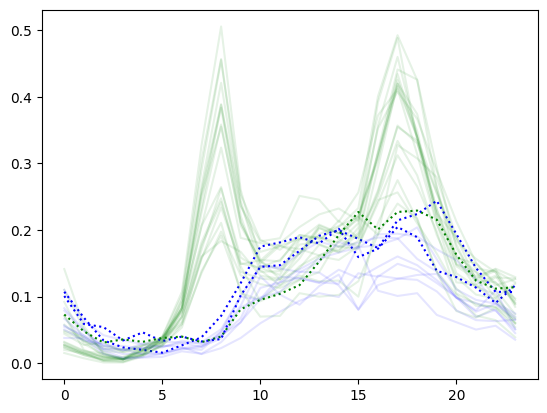

In [30]:
preds = (model(X_test) > 0).detach().int().numpy()
trues = y_test.numpy()

for i in range(len(X_test)):
    plt.plot(np.arange(24), X_test[i, :, 0].numpy(),
             color = ["blue", "green"][int(trues[i])],
             ls = [":", "-"][int(trues[i] == preds[i])],
             alpha = [1, 0.1][int(trues[i] == preds[i])],
            )